In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/squad-v11/SQuAD-v1.2.csv
/kaggle/input/squad-v11/SQuAD-v1.1.csv


In [2]:
import os 
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
import tensorflow_datasets as tfds
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from time import time
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df=pd.read_csv('/kaggle/input/squad-v11/SQuAD-v1.1.csv')

In [4]:
df.head()

,title,context,question,answer,answer_start,answer_end
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126


In [5]:
def replace_phrase(text):
        text = text.lower()
        text = re.sub(r"there's", "there is", str(text))
        text = re.sub(r"i'm", "i am",  str(text))
        text = re.sub(r"he's", "he is",  str(text))
        text = re.sub(r"she's", "she is",  str(text))
        text = re.sub(r"it's", "it is",  str(text))
        text = re.sub(r"that's", "that is",  str(text))
        text = re.sub(r"what's", "that is",  str(text))
        text = re.sub(r"where's", "where is",  str(text))
        text = re.sub(r"how's", "how is",  str(text))
        text = re.sub(r"\'ll", " will",  str(text))
        text = re.sub(r"\'ve", " have",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"\'d", " would",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"won't", "will not",  str(text))
        text = re.sub(r"can't", "cannot",  str(text))
        text = re.sub(r"n't", " not",  str(text))
        text = re.sub(r"n'", "ng",  str(text))
        text = re.sub(r"'bout", "about",  str(text))
        text = re.sub(r"'til", "until",  str(text))
        text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "",  str(text))
        text = text.strip()
        return text

In [6]:
df = df.iloc[:3000]

In [7]:
df.shape

(3000, 6)

In [8]:
%%time
cleaned_context=df.context.apply(replace_phrase)
cleaned_question=df.question.apply(replace_phrase)
cleaned_answer=df.answer.apply(replace_phrase)

CPU times: user 404 ms, sys: 2.79 ms, total: 407 ms
Wall time: 407 ms


In [9]:
cleaned_context[:10]

0    architecturally the school has a catholic char...
1    architecturally the school has a catholic char...
2    architecturally the school has a catholic char...
3    architecturally the school has a catholic char...
4    architecturally the school has a catholic char...
5    as at most other universities notre dame's stu...
6    as at most other universities notre dame's stu...
7    as at most other universities notre dame's stu...
8    as at most other universities notre dame's stu...
9    as at most other universities notre dame's stu...
Name: context, dtype: object

In [10]:
df['cleaned_context']=cleaned_context
df['cleaned_question']=cleaned_question
df['cleaned_answer']=cleaned_answer
df.head()

,title,context,question,answer,answer_start,answer_end,cleaned_context,cleaned_question,cleaned_answer
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541,architecturally the school has a catholic char...,to whom did the virgin mary allegedly appear i...,saint bernadette soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213,architecturally the school has a catholic char...,what is in front of the notre dame main building,a copper statue of christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296,architecturally the school has a catholic char...,the basilica of the sacred heart at notre dame...,the main building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420,architecturally the school has a catholic char...,what is the grotto at notre dame,a marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126,architecturally the school has a catholic char...,what sits on top of the main building at notre...,a golden statue of the virgin mary


In [11]:
df.to_csv('/kaggle/working/squad.csv')

In [12]:
def set_input_tokens(pairs):
        input_lines, input_seq_length = [], []

        for line in pairs.cleaned_question:
            input_lines.append(line)

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(input_lines)
        tokenized_input_lines = tokenizer.texts_to_sequences(input_lines)

        for token_seq in tokenized_input_lines:
            input_seq_length.append(len(token_seq))

        max_input_seq_len = np.array(input_seq_length).max()

        print("Max. input sequence length is {}".format(max_input_seq_len))

        return tokenized_input_lines, max_input_seq_len, tokenizer

In [13]:
tokenized_input_lines, max_input_seq_len, tokenizer =set_input_tokens(df)

Max. input sequence length is 29


In [14]:
def pad_input_lines(tokenized_input_lines, max_input_seq_len, tokenizer):
        padded_input_lines = pad_sequences(tokenized_input_lines,maxlen=max_input_seq_len,padding='post')
        encoder_input_data = np.array(padded_input_lines)

        print('Encoder input data shape: {}'.format(encoder_input_data.shape))

        input_word_dict = tokenizer.word_index
        num_input_tokens = len(input_word_dict) + 1

        print("Number of input tokens = {}".format(num_input_tokens))

        return encoder_input_data, input_word_dict, num_input_tokens

In [15]:
encoder_input_data, input_word_dict, num_input_tokens=pad_input_lines(tokenized_input_lines, max_input_seq_len, tokenizer)

Encoder input data shape: (3000, 29)
Number of input tokens = 4430


In [16]:
def set_output_tokens(pairs):
        output_lines, output_len_list = [], []

        for line in pairs.cleaned_answer:
            output_lines.append('<START> ' + line + ' <END>')

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(output_lines)
        tokenized_output_lines = tokenizer.texts_to_sequences(output_lines)

        for token_seq in tokenized_output_lines:
            output_len_list.append(len(token_seq))

        max_output_len = np.array(output_len_list).max()
        print("Output max length is {}".format(max_output_len))

        return tokenized_output_lines, max_output_len, tokenizer

In [17]:
tokenized_output_lines, max_output_len, decoder_tokenizer=set_output_tokens(df)

Output max length is 29


In [18]:
def pad_output_lines(tokenized_output_lines, max_output_len, decoder_tokenizer):
        padded_output_lines = pad_sequences(tokenized_output_lines,
                                                                   maxlen=max_output_len,
                                                                   padding="post")
        decoder_input_data = np.array(padded_output_lines)
        print("Decoder input data shape: {}".format(decoder_input_data.shape))

        output_word_dict = decoder_tokenizer.word_index
        num_output_tokens = len(output_word_dict) + 1
        print("Number of output tokens: {}".format(num_output_tokens))

        return decoder_input_data, output_word_dict, num_output_tokens

In [19]:
decoder_input_data, output_word_dict, num_output_tokens=pad_output_lines(tokenized_output_lines, max_output_len, decoder_tokenizer)

Decoder input data shape: (3000, 29)
Number of output tokens: 2988


In [20]:
def set_target_tokens(tokenized_output_lines, max_output_len, num_output_tokens):
    decoder_target_data = []

    for token_seq in tokenized_output_lines:
        decoder_target_data.append(token_seq[1:])

    padded_output_lines = pad_sequences(decoder_target_data,
                                                               maxlen=max_output_len,
                                                               padding='post')
    onehot_output_lines = tf.keras.utils.to_categorical(padded_output_lines, num_output_tokens)
    decoder_target_data = np.array(onehot_output_lines)
    print('Decoder target data shape: {}'.format(decoder_target_data.shape))

    return decoder_target_data

In [21]:
decoder_target_data=set_target_tokens(tokenized_output_lines, max_output_len, num_output_tokens)

Decoder target data shape: (3000, 29, 2988)


In [22]:
dimensionality = 512
batch_size = 32
epochs = 100
model_name = "model.h5"
plot_name = "acc.png"

In [23]:
def train_model(num_input_tokens, num_output_tokens):

        encoder_inputs = Input(shape=(None, ))
        encoder_embedding = Embedding(num_input_tokens, dimensionality, mask_zero=True)(encoder_inputs)
        encoder_outputs, state_h, state_c = LSTM(dimensionality, return_state=True, recurrent_dropout=0.2,
                                                 dropout=0.2)(encoder_embedding)
        encoder_states = [state_h, state_c]

        decoder_inputs = Input(shape=(None,))
        decoder_embedding = Embedding(num_output_tokens, dimensionality, mask_zero=True)(decoder_inputs)
        decoder_lstm = LSTM(dimensionality, return_state=True, return_sequences=True,
                            recurrent_dropout=0.2, dropout=0.2)
        decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
        decoder_dense = Dense(num_output_tokens, activation=tf.keras.activations.softmax)
        output = decoder_dense(decoder_outputs)

        model = Model([encoder_inputs, decoder_inputs], output)
            
        model.summary()
            
        return model

In [24]:
model=train_model(num_input_tokens,num_output_tokens)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 512)            2268160   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 512)            1529856   ['input_2[0][0]']             
                                                                                              

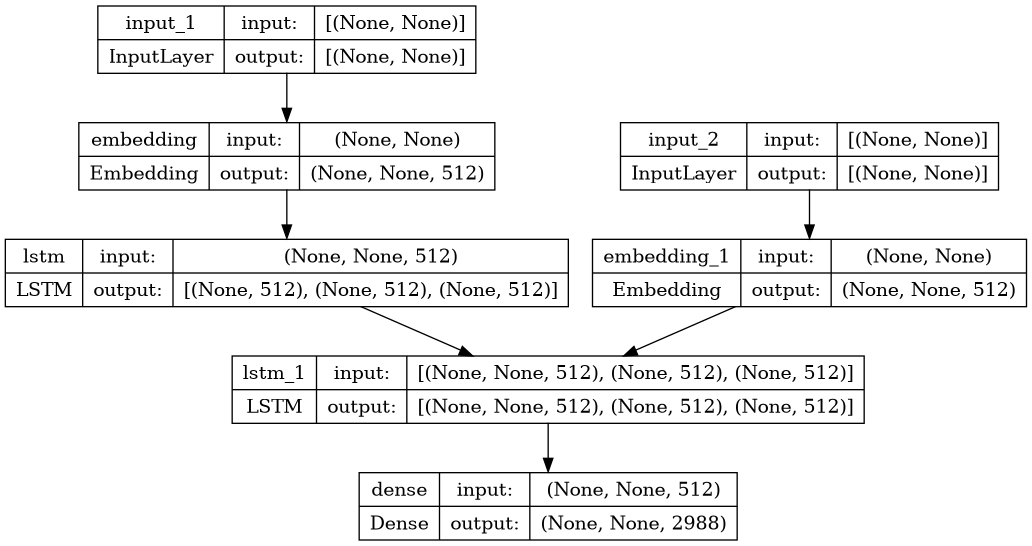

In [42]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/model.png', show_shapes=True, show_layer_names=True)


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
filepath='/kaggle/working/'+model_name

In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_best_only=True,
                                                 verbose=1)

In [28]:
with tf.device('/gpu:0'):
                history = model.fit([encoder_input_data, decoder_input_data],
                                    decoder_target_data,
                                    validation_split=0.33,
                                    batch_size=batch_size,
                                    callbacks=[cp_callback],
                                    epochs=epochs,
                                    shuffle=True)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 5.2798 - accuracy: 0.3900
Epoch 1: val_loss improved from inf to 4.91687, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 46s 521ms/step - loss: 5.2798 - accuracy: 0.3900 - val_loss: 4.9169 - val_accuracy: 0.4675
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 4.2239 - accuracy: 0.4485
Epoch 2: val_loss did not improve from 4.91687
63/63 [==============================] - 23s 361ms/step - loss: 4.2239 - accuracy: 0.4485 - val_loss: 5.1054 - val_accuracy: 0.4936
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 3.9275 - accuracy: 0.4519
Epoch 3: val_loss did not improve from 4.91687
63/63 [==============================] - 20s 313ms/step - loss: 3.9275 - accuracy: 0.4519 - val_loss: 5.3292 - val_accuracy: 0.4960
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 3.7364 - accuracy: 0.4573
Epoch 4: val_loss did not improve from 4.91687
63/63 [==============================] - 18s 287ms/step - loss: 3.7364 - accuracy: 0.4573 - val_loss: 5.5353 - val_accuracy: 0.4953
Epoch 5/100
63/63 [===========================

In [31]:
acc_image_path='/kaggle/working/'+plot_name
def save_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('Accuracy- Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'loss'], loc='upper left')
    plt.savefig(acc_image_path)

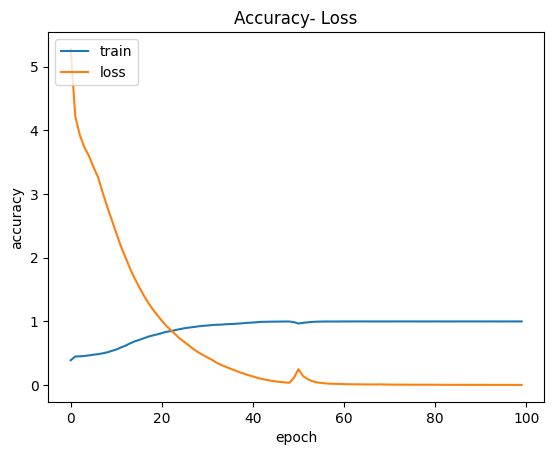

In [32]:
save_history(history)

In [33]:
enc_path='/kaggle/working/'+"enc_model.h5"
dec_path='/kaggle/working/'+"dec_model.h5"

In [38]:
import io
import json
model.save('/kaggle/working/my_h5_model.h5')

source_tokenizer_json = tokenizer.to_json()
with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
      f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

target_tokenizer_json = decoder_tokenizer.to_json()
with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
      f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

In [52]:
model = tf.keras.models.load_model('/kaggle/working/my_h5_model.h5')

In [53]:
encoder_inputs = model.get_layer('input_1').input####1

encoder_embedding_layer = model.get_layer('embedding')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]###2

decoder_inputs = model.get_layer('input_2').input

decoder_embedding_layer = model.get_layer('embedding_1')
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = model.get_layer('lstm_1')###3

decoder_dense = model.get_layer('dense')


In [54]:
def make_inference_models(encoder_inputs, encoder_states, decoder_lstm,
                              decoder_embedding, decoder_dense, decoder_inputs):

        encoder_model = Model(encoder_inputs, encoder_states)
        decoder_state_input_h = Input(shape=(dimensionality,))
        decoder_state_input_c = Input(shape=(dimensionality,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)

        decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)

        encoder_model.save(enc_path)
        decoder_model.save(dec_path)

        return encoder_model, decoder_model

In [55]:
encoder_model, decoder_model=make_inference_models(encoder_inputs, encoder_states, decoder_lstm,
                              decoder_embedding, decoder_dense, decoder_inputs)

In [56]:
def str_to_tokens(sentence: str, input_word_dict, max_input_length):
        tokens_list = []

        words = sentence.lower().split()

        try:
            for word in words:
                tokens_list.append(input_word_dict[word])
        except Exception as e:
            print(f" ' {word} 'not exist in the vocabulary".format(word=word))

        return pad_sequences([tokens_list], maxlen=max_input_length, padding='post')

In [57]:
def predict(user_input):
        stop_condition = False
        decoded_translation = ''

        if not os.path.exists(enc_path) and not os.path.exists(dec_path):

            encoder_inputs = Input(shape=(None,))
            encoder_embedding = Embedding(num_input_tokens, dimensionality, mask_zero=True)(encoder_inputs)
            encoder_outputs, state_h, state_c = LSTM(dimensionality, return_state=True,
                                                     recurrent_dropout=0.2, dropout=0.2)(encoder_embedding)
            encoder_states = [state_h, state_c]

            decoder_inputs = Input(shape=(None,))
            decoder_embedding = Embedding(num_output_tokens, dimensionality, mask_zero=True)(decoder_inputs)
            decoder_lstm = LSTM(dimensionality, return_state=True, return_sequences=True,
                                recurrent_dropout=0.2, dropout=0.2)
            decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
            decoder_dense = Dense(num_output_tokens, activation=tf.keras.activations.softmax)
            output = decoder_dense(decoder_outputs)

            enc_model, dec_model = make_inference_models(encoder_inputs, encoder_states, decoder_lstm,
                                                              decoder_embedding, decoder_dense, decoder_inputs)
        else:
            enc_model = load_model(enc_path)
            dec_model = load_model(dec_path)

        states_values = enc_model.predict(str_to_tokens(user_input, input_word_dict, max_input_seq_len))

        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = output_word_dict['start']

        while not stop_condition:

            dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
            sampled_word_index = np.argmax(dec_outputs[0, -1, :])
            sampled_word = None

            for word, index in output_word_dict.items():
                if sampled_word_index == index:
                    decoded_translation += ' {}'.format(word)
                    sampled_word = word

            if sampled_word == 'end' or len(decoded_translation.split()) > max_output_len:
                stop_condition = True

            empty_target_seq = np.zeros((1, 1))
            empty_target_seq[0, 0] = sampled_word_index
            states_values = [h, c]

        return decoded_translation.replace("end", "")

In [63]:
user_input=input()
predict(user_input)

 When did the Scholastic Magazine of Notre dame begin publishing?


 ' publishing? 'not exist in the vocabulary
1/1 [==============================] - 0s 20ms/step


' 1876 '

In [66]:
user_input=input()
predict(user_input)

 How many student news papers are found at Notre Dame?


 ' dame? 'not exist in the vocabulary
1/1 [==============================] - 0s 22ms/step


' three '

In [75]:
user_input=input()
predict(user_input)

 How many BS level degrees are offered in the College of Engineering at Notre Dame?


 ' dame? 'not exist in the vocabulary
1/1 [==============================] - 0s 23ms/step


' eight '

In [77]:
user_input=input()
predict(user_input)

 How many departments are within the Stinson-Remick Hall of Engineering?


 ' stinson-remick 'not exist in the vocabulary
1/1 [==============================] - 0s 22ms/step


' five '